In [1]:
import os
import time
import copy
import numpy as n
import numpy.lib.recfunctions as rfn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
import umap
import matplotlib
from sklearn.decomposition import PCA

In [70]:
def load_data(data_root, dlc_dir, ann_dir, verbose=False):
    
    dlc_path = os.path.join(data_root, dlc_dir)
    ann_path = os.path.join(data_root, ann_dir)
    all_data = {}
    if verbose: print("Loading files: ")
    for f_name in os.listdir(dlc_path):
        if f_name[-3:] != 'npy':
            continue

        dlc_file=os.path.join(dlc_path, f_name)
        ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
        if verbose: print("\t" + f_name + "\n\tAnnotated_" + f_name)
        data_dlc = n.load(dlc_file)
        data_ann = n.load(ann_file)
        labels = data_dlc[0]
        dtype = [('t', n.int), ('ann', 'U30')]
        i = 0
        for label in data_dlc[0]:
            i += 1
            coord = 'x' if i % 2 == 0 else 'y'
            dtype += [(label + '_' + coord , n.float32 )]

        data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
        data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
        for i in range(data_concat.shape[1]):
            data[dtype[i][0]] = data_concat[:, i]
        all_data[f_name[:-4]] = data
    return all_data
def extract_data(trial):
    num_markers = int((len(trial.dtype.names)-2)/2)

    all_labels = trial.dtype.names[2:]

    markers_1 = []
    markers_2 = []
    positions_1 = n.zeros((trial.shape[0], int(num_markers/2), 2))
    positions_2 = n.zeros((trial.shape[0], int(num_markers/2), 2))

    for i in range(num_markers):
        label = all_labels[i*2][:-2]
        label_x = label+'_x'
        label_y = label+'_y'
        if label[-1] == '1':
            markers_1.append(label)
            idx = len(markers_1)-1
            positions_1[:,idx, 0] = trial[label_x]
            positions_1[:,idx, 1] = trial[label_y]
        else:
            markers_2.append(label)
            idx = len(markers_2)-1
            positions_2[:,idx,0] = trial[label_x]
            positions_2[:,idx,1] = trial[label_y]
    return n.array(markers_1), n.array(markers_2), positions_1, positions_2

In [88]:
# LOAD RAW DATA
data_root = '/mnt/d/Ali/Google Drive/SWC/Experimental Neuroscience/social and affective systems/rat_social_beh'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'
dlc_path = os.path.join(data_root, dlc_dir)
ann_path = os.path.join(data_root, ann_dir)

all_data = load_data(data_root, dlc_dir, ann_dir)

In [97]:
# PROCESS RAW DATA
# 45: since the first n_window/2 frames lack latents in the VAME output
trial = all_data['Female1'][45:]
mark_1, mark_2, pos_1, pos_2 = extract_data(trial)
unique_labels = n.unique(trial['ann'])
label_map = {}; i=0
for u in unique_labels: label_map[u] = i; i+=1
labels = n.array([label_map[trial['ann'][i]] for i in range((pos_1.shape[0]))])

In [4]:
# LOAD VAME DATA
path = '/mnt/d/single-mouse-f1-Nov20-2020/results/Female1/VAME/kmeans-15'

beh = {}
for file in os.listdir(os.path.join(path, 'behavior_quantification')):
    beh[file[:-4]] = n.load(os.path.join(path, 'behavior_quantification',file))
k_means_labels = n.load(os.path.join(path, '15_km_label_Female1.npy'))
latent_vectors = n.load(os.path.join(path, 'latent_vector_Female1.npy'))


In [77]:
# PCA EMBEDDINGS 
pca = PCA(n_components=2)
pca_embed = pca.fit(latent_vectors).transform(latent_vectors)

In [125]:
latent_vectors.shape

(30225, 30)

In [127]:
umap_embed.shape

(30225, 2)

In [78]:
# UMAP EMBEDDINGS
reducer = umap.UMAP(random_state=42)
reducer.fit(latent_vectors)
umap_embed = reducer.transform(latent_vectors)
assert(n.all(umap_embed == reducer.embedding_))

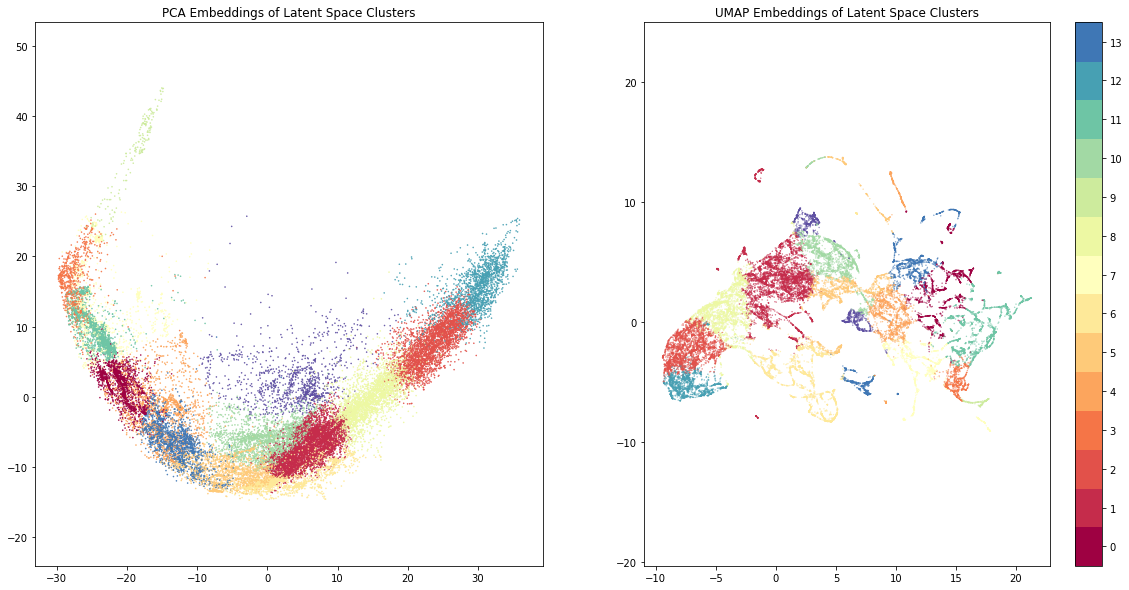

In [134]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
scatter = axs[0].scatter(pca_embed[:,0], pca_embed[:,1],s=0.3,cmap='Spectral', c=k_means_labels)
axs[0].set_title("PCA Embeddings of Latent Space Clusters")
axs[0].set_aspect('equal', 'datalim')
axs[1].scatter(umap_embed[:, 0], umap_embed[:, 1], c=k_means_labels, cmap='Spectral', s=0.1)
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title("UMAP Embeddings of Latent Space Clusters")
cb = plt.colorbar(scatter,boundaries=n.arange(n.max(k_means_labels)+1)-0.5).set_ticks(n.arange(n.max(k_means_labels)))

Text(0.5, 1.0, 'UMAP Embeddings of Latent Space Clusters')

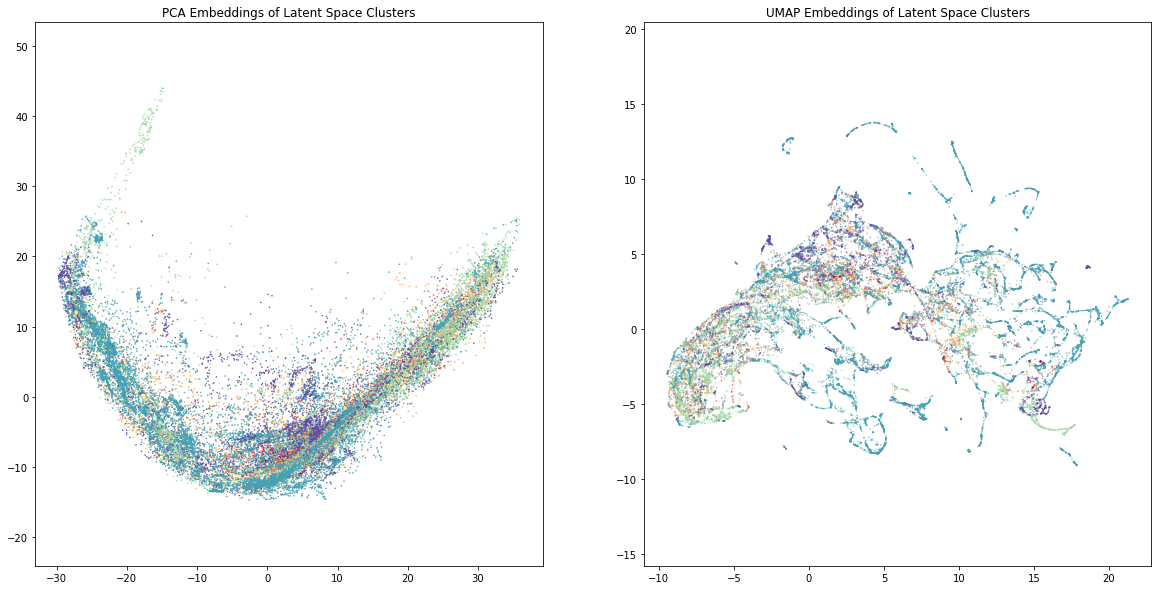

In [123]:
# Plot with annotation color labels - not good
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].scatter(pca_embed[:,0], pca_embed[:,1],s=0.3, c=labels, cmap='Spectral')
axs[0].set_title("PCA Embeddings of Latent Space Clusters")
axs[0].set_aspect('equal', 'datalim')
axs[1].scatter(umap_embed[:, 0], umap_embed[:, 1], c=labels, s=0.1, cmap='Spectral')
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title("UMAP Embeddings of Latent Space Clusters")

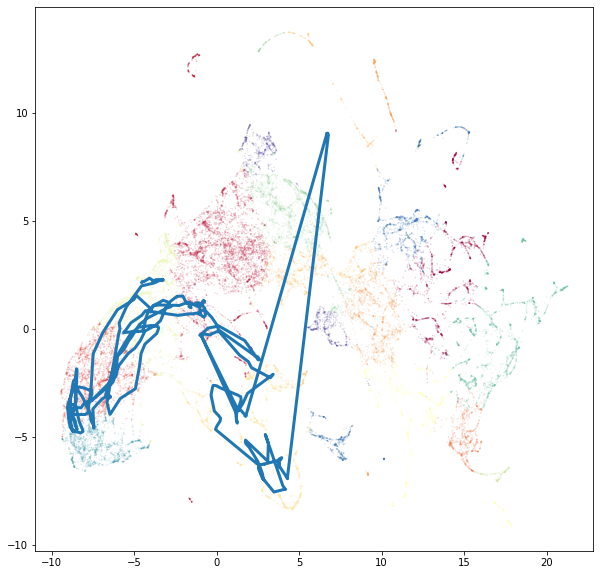

In [114]:
plt.figure(figsize=(10,10))
t_start = 1500
t_end = 2000
plt.plot(umap_embed[t_start:t_end, 0], umap_embed[t_start:t_end, 1], linewidth=3)
plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=k_means_labels, cmap='Spectral', s=0.1, alpha=0.3)
axs[1].set_aspect('equal', 'datalim')

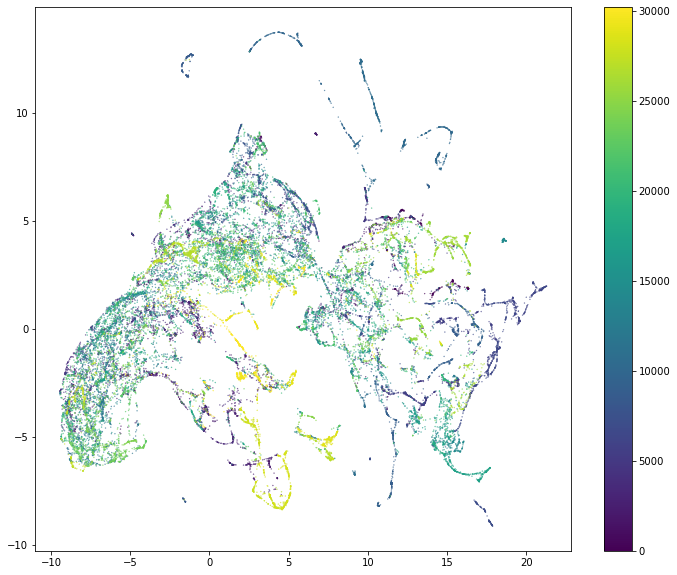

In [121]:
plt.figure(figsize=(12,10))
plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=range(umap_embed.shape[0]), s=0.1)
plt.colorbar()
axs[1].set_aspect('equal', 'datalim')

In [113]:
import cv2
video_name = 'dlc_videos/Female1.mp4'
vidcap = cv2.VideoCapture(os.path.join(data_root,video_name))
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames


ModuleNotFoundError: No module named 'cv2'

In [ ]:
sec = 0
frameRate = 0.5 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)